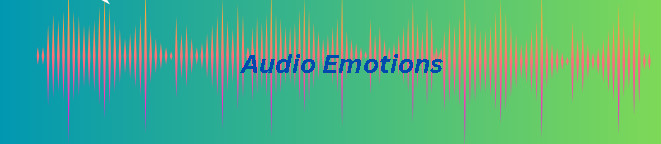

In [1]:
import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.get_logger().setLevel('ERROR')

import warnings

warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly
from scipy.io import wavfile
from scipy.fftpack import fft
import cv2
import os
import librosa
import librosa.display
import IPython.display as ipd
from glob import glob
import skimage
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from pydub import AudioSegment
from tqdm import tqdm
import tempfile

### Load the audio data

In [3]:
def load_files(directory):
    emotions_sounds = []
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith(".wav"):
            sound = AudioSegment.from_file(os.path.join(directory, filename))
            emotions_sounds.append(sound)
    return emotions_sounds 

In [4]:
angry_sounds = load_files('/kaggle/input/audio-emotions/Emotions/Angry/')
print("Angry sounds loaded successfully")
disgusted_sounds = load_files('/kaggle/input/audio-emotions/Emotions/Disgusted/')
print("Disgusted sounds loaded successfully")
fearful_sounds = load_files('/kaggle/input/audio-emotions/Emotions/Fearful/')
print("Fearful sounds loaded successfully")
happy_sounds = load_files('/kaggle/input/audio-emotions/Emotions/Happy/')
print("Happy sounds loaded successfully")
neutral_sounds = load_files('/kaggle/input/audio-emotions/Emotions/Neutral/')
print("Neutral sounds loaded successfully")
sad_sounds = load_files('/kaggle/input/audio-emotions/Emotions/Sad/')
print("Sad sounds loaded successfully")
suprised_sounds = load_files('/kaggle/input/audio-emotions/Emotions/Suprised/')
print("Suprised sounds loaded successfully")

100%|██████████| 2167/2167 [00:15<00:00, 139.85it/s]


Angry sounds loaded successfully


100%|██████████| 1863/1863 [00:11<00:00, 155.74it/s]


Disgusted sounds loaded successfully


100%|██████████| 2047/2047 [00:13<00:00, 155.73it/s]


Fearful sounds loaded successfully


100%|██████████| 2167/2167 [00:14<00:00, 152.03it/s]


Happy sounds loaded successfully


100%|██████████| 1795/1795 [00:11<00:00, 151.32it/s]


Neutral sounds loaded successfully


100%|██████████| 2167/2167 [00:14<00:00, 149.53it/s]


Sad sounds loaded successfully


100%|██████████| 592/592 [00:03<00:00, 162.88it/s]

Suprised sounds loaded successfully


In [5]:
def waveform(path, path_name):
    signal, sample_rate = librosa.load(path)
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(signal, sr=sample_rate)

    plt.title(F'The {path_name} Sound Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

    print(F"The {path_name} Sound: ")
    sound = ipd.Audio(signal, rate=sample_rate)

    return sound

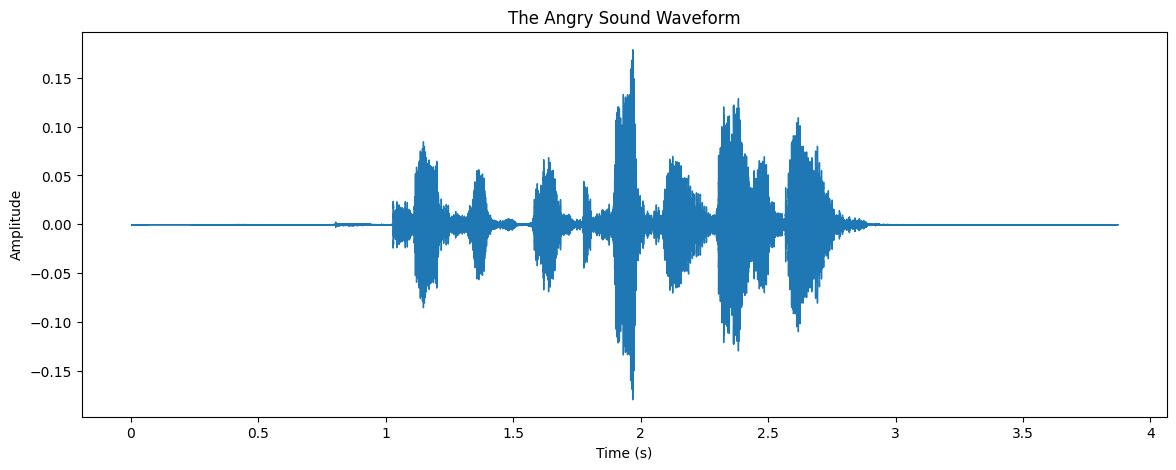

The Angry Sound: 


In [6]:
waveform('/kaggle/input/audio-emotions/Emotions/Angry/03-01-05-01-01-01-01.wav','Angry')

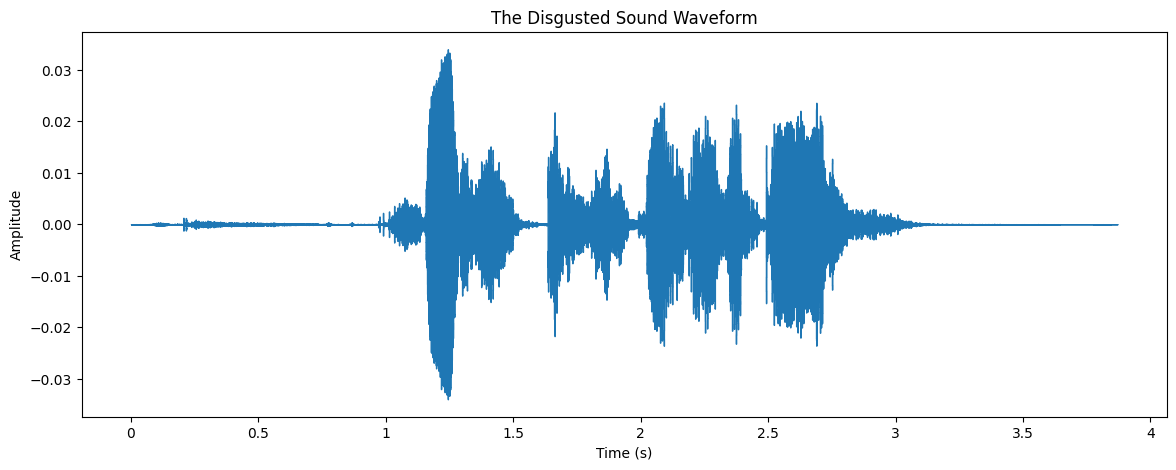

The Disgusted Sound: 


In [7]:
waveform('/kaggle/input/audio-emotions/Emotions/Disgusted/03-01-07-01-01-01-01.wav','Disgusted')

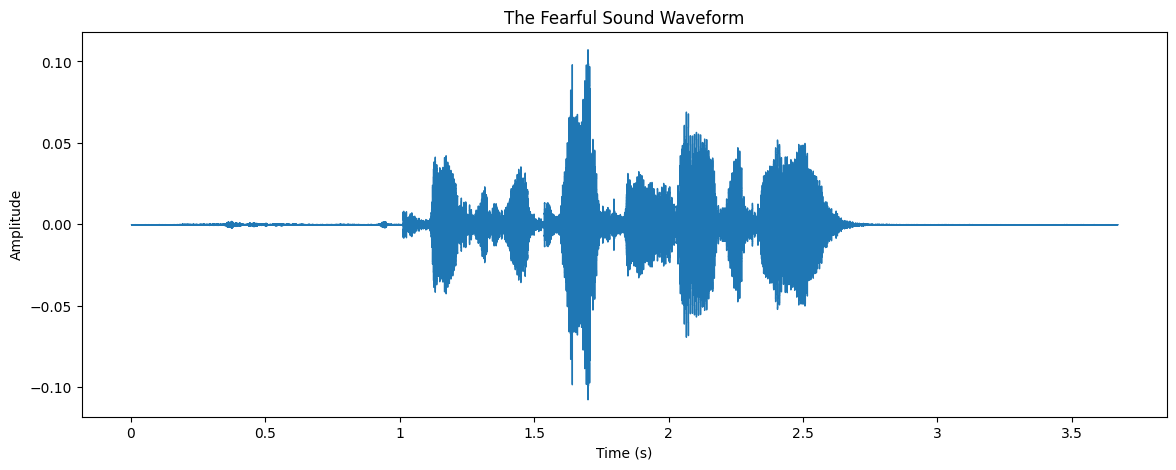

The Fearful Sound: 


In [8]:
waveform('/kaggle/input/audio-emotions/Emotions/Fearful/03-01-06-01-01-01-01.wav','Fearful')

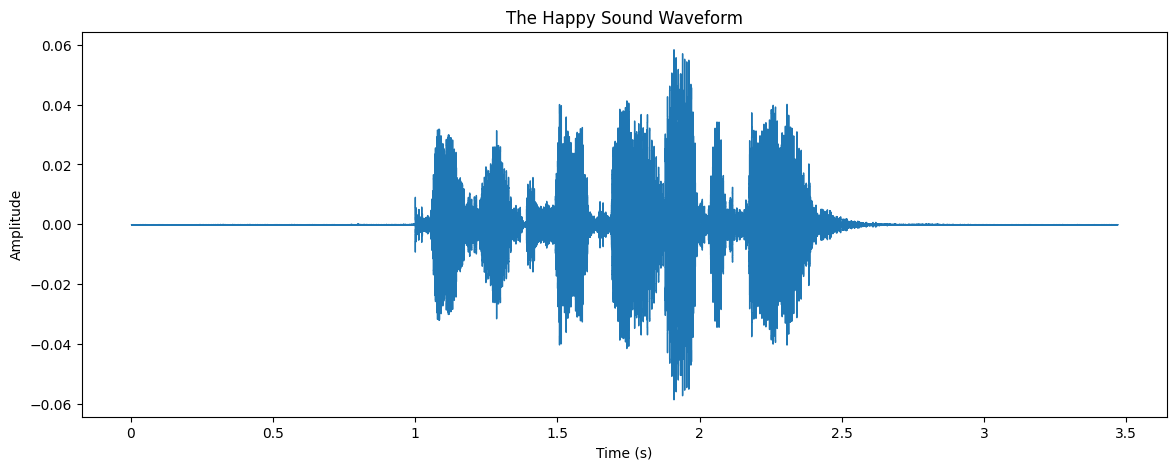

The Happy Sound: 


In [9]:
waveform('/kaggle/input/audio-emotions/Emotions/Happy/03-01-03-01-01-01-01.wav','Happy')

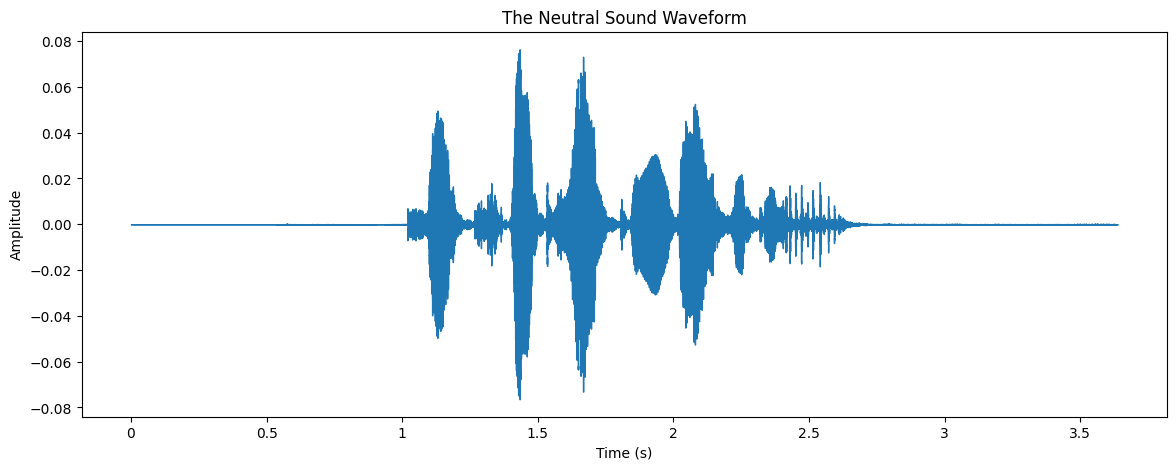

The Neutral Sound: 


In [10]:
waveform('/kaggle/input/audio-emotions/Emotions/Neutral/03-01-01-01-01-01-02.wav','Neutral')

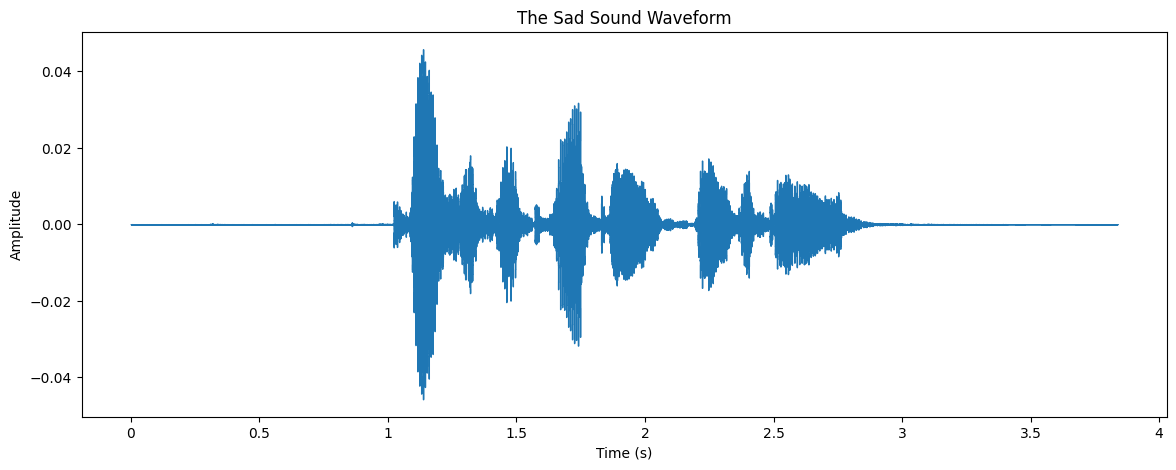

The Sad Sound: 


In [11]:
waveform('/kaggle/input/audio-emotions/Emotions/Sad/03-01-04-01-01-01-01.wav','Sad')

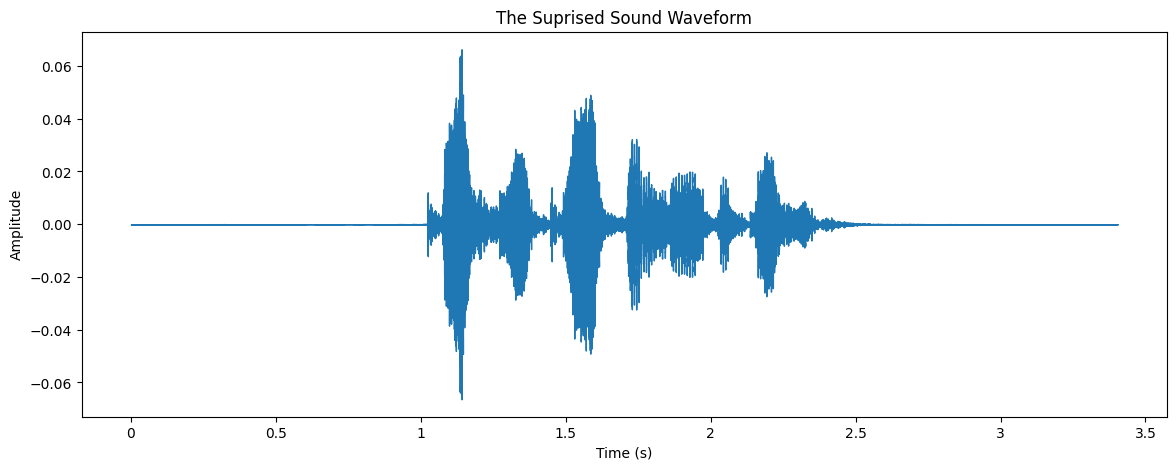

The Suprised Sound: 


In [12]:
waveform('/kaggle/input/audio-emotions/Emotions/Suprised/03-01-08-01-01-01-01.wav','Suprised')

### Melspectrograms

In [13]:
def do_melspectrogram(sound_files):
    sample_rate = 44100  

    mel_spectrogram_dbs_list = []

    for i in tqdm(range(len(sound_files))):
        
        audio_segment = sound_files[i]

        temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".wav")
        temp_file_path = temp_file.name
        temp_file.close()

        
        audio_segment.export(temp_file_path, format="wav")

    
        signal, sample_rate = librosa.load(temp_file_path, sr=sample_rate)

        os.remove(temp_file_path)

        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate) 

        mel_spectrogram_dbs = librosa.power_to_db(mel_spectrogram, ref=np.max)

        mel_spectrogram_dbs_list.append(mel_spectrogram_dbs)

    return mel_spectrogram_dbs_list

In [14]:
def show_mel_spectrogram(mel_spectrogram):  
    df_mel_spectrogram = pd.DataFrame(mel_spectrogram)
    plt.figure(figsize=(10, 4))
    sns.heatmap(df_mel_spectrogram, cmap='plasma', xticklabels=10, yticklabels=10)
    plt.title(f'Mel Spectrogram  (dB)')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel Frequency Bin')
    plt.show()

In [15]:
mel_spectrogram_dbs_angry = do_melspectrogram(angry_sounds)

100%|██████████| 2167/2167 [01:03<00:00, 34.23it/s]


In [16]:
mel_spectrogram_dbs_angry[0]

array([[-58.2556  , -51.786583, -48.304146, ..., -43.381824, -41.867054,
        -47.437035],
       [-53.360737, -51.744186, -49.54957 , ..., -45.95514 , -46.044422,
        -55.272583],
       [-48.58745 , -47.750904, -44.783142, ..., -47.276627, -53.806255,
        -55.600235],
       ...,
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ]], dtype=float32)

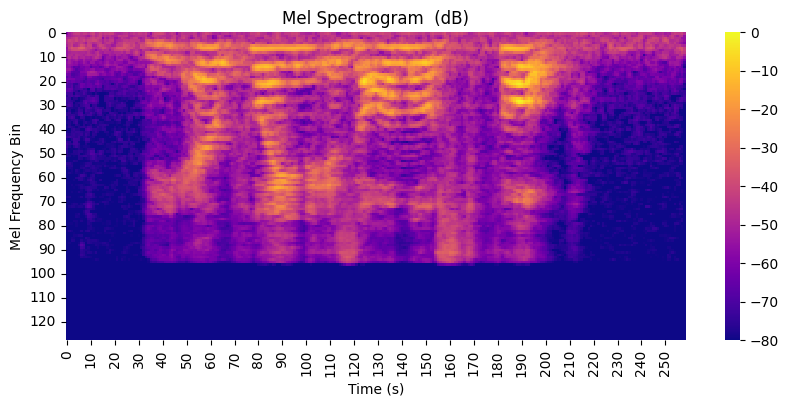

In [17]:
show_mel_spectrogram(mel_spectrogram_dbs_angry[0])

In [18]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Surface(z=mel_spectrogram_dbs_angry[0].T, colorscale='viridis')
])

fig.update_layout(
    title='Mel Spectrogram (dB)',
    scene=dict(
        xaxis=dict(title='Time (s)'),
        yaxis=dict(title='Mel Frequency Bin'),
        zaxis=dict(title='Amplitude (dB)')
    )
)

fig.show()

In [19]:
from scipy.signal import find_peaks

def findPeeks(signals, signals_name):
    signals_flat = signals.flatten()

    h = signals_flat.max() * 5 / 100

    peaks, _ = find_peaks(signals_flat, distance=10, height=h)
    plt.figure(figsize=(10, 6))
    plt.plot(signals_flat, label=F'{signals_name}')
    plt.plot(peaks, signals_flat[peaks], 'x', color='red', label='Peaks')
    plt.xlabel('Frame')
    plt.ylabel(F'{signals_name} Value')
    plt.title(F'{signals_name} with Peaks')
    plt.legend()
    plt.show()

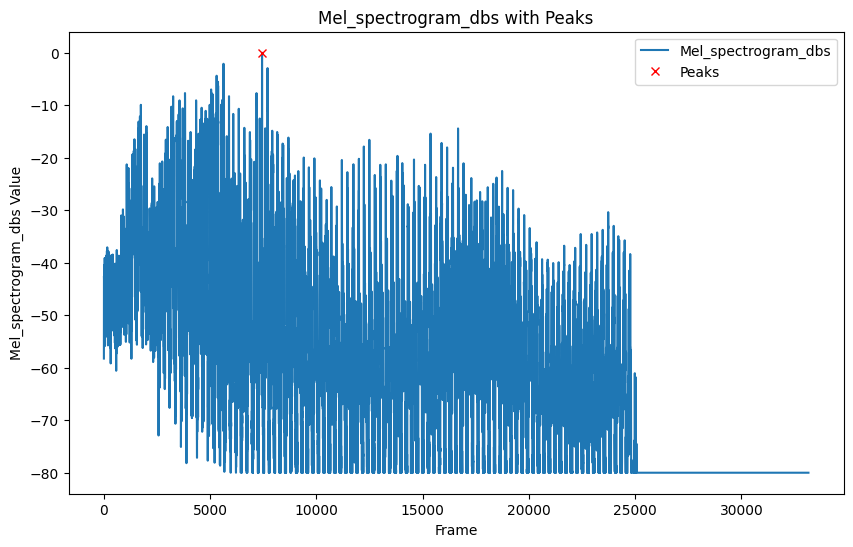

In [20]:
findPeeks(mel_spectrogram_dbs_angry[0],'Mel_spectrogram_dbs')

In [21]:
mel_spectrogram_dbs_disgusted = do_melspectrogram(disgusted_sounds)

100%|██████████| 1863/1863 [00:53<00:00, 34.96it/s]


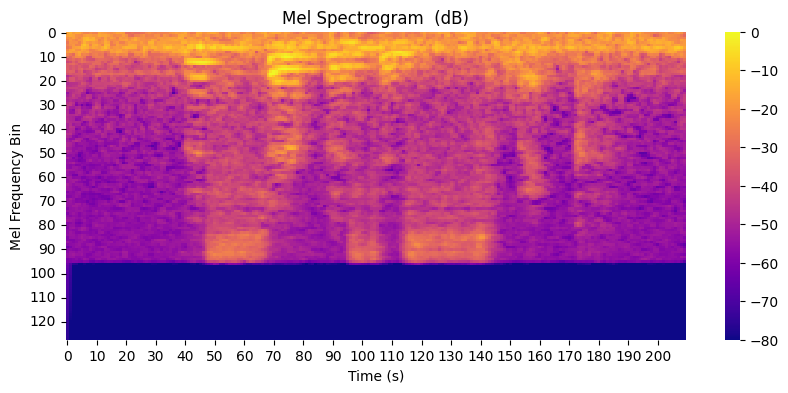

In [22]:
show_mel_spectrogram(mel_spectrogram_dbs_disgusted[0])

In [23]:
mel_spectrogram_dbs_fearful = do_melspectrogram(fearful_sounds)

100%|██████████| 2047/2047 [00:57<00:00, 35.33it/s]


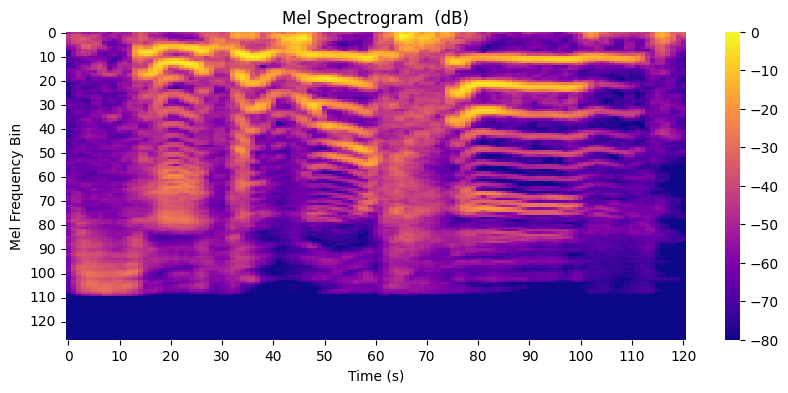

In [24]:
show_mel_spectrogram(mel_spectrogram_dbs_fearful[0])

In [25]:
mel_spectrogram_dbs_happy = do_melspectrogram(happy_sounds)

100%|██████████| 2167/2167 [01:02<00:00, 34.91it/s]


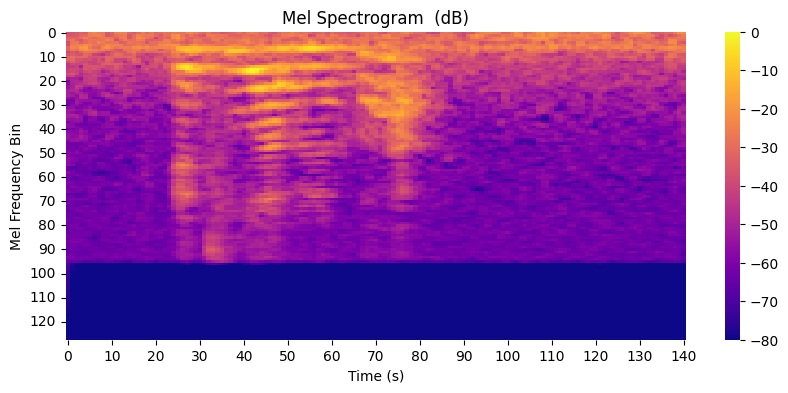

In [26]:
show_mel_spectrogram(mel_spectrogram_dbs_happy[0])

In [27]:
mel_spectrogram_dbs_neutral = do_melspectrogram(neutral_sounds)

100%|██████████| 1795/1795 [00:50<00:00, 35.51it/s]


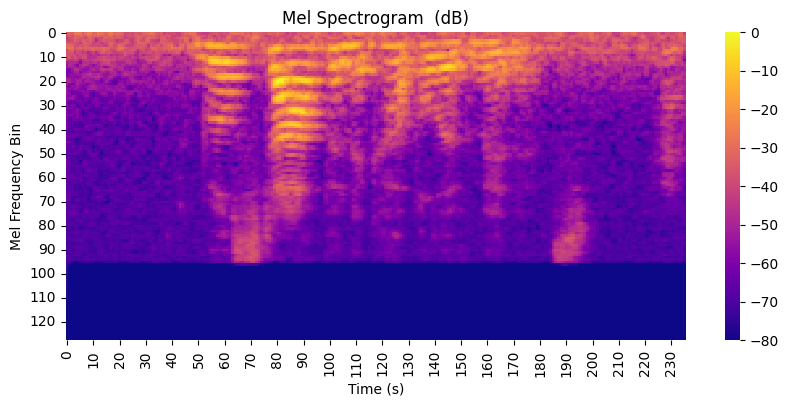

In [28]:
show_mel_spectrogram(mel_spectrogram_dbs_neutral[0])

In [29]:
mel_spectrogram_dbs_sad = do_melspectrogram(sad_sounds)

100%|██████████| 2167/2167 [01:04<00:00, 33.42it/s]


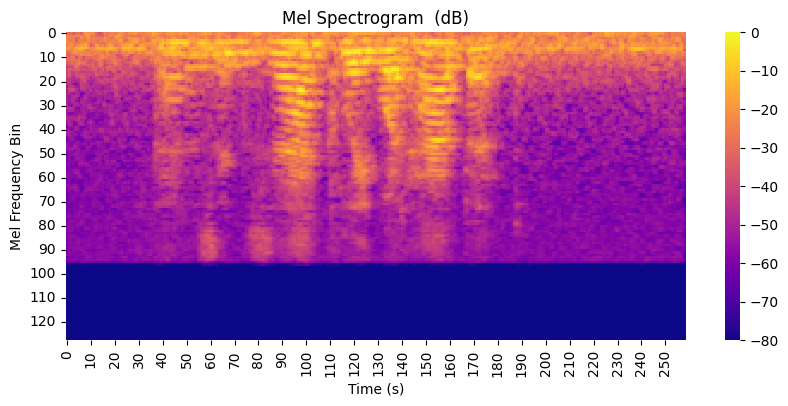

In [30]:
show_mel_spectrogram(mel_spectrogram_dbs_sad[0])

In [31]:
mel_spectrogram_dbs_suprised = do_melspectrogram(suprised_sounds)

100%|██████████| 592/592 [00:17<00:00, 34.16it/s]


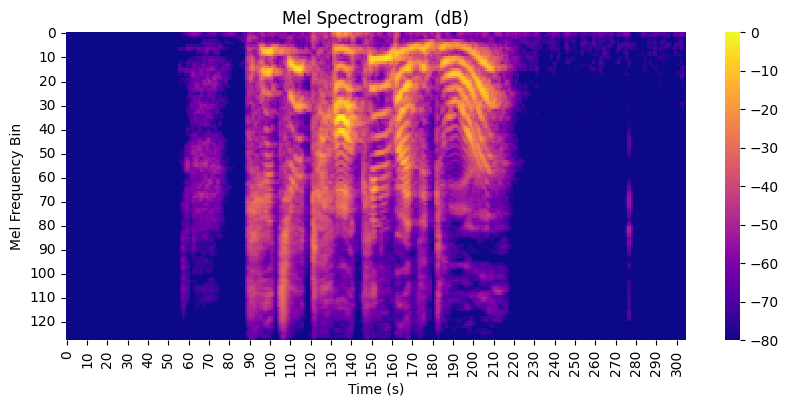

In [32]:
show_mel_spectrogram(mel_spectrogram_dbs_suprised[0])

## Compute MFCCs
MFCC stands for Mel-frequency cepstral coefficients. It is a feature widely used in audio and speech processing for tasks such as speech recognition, speaker identification, and music genre classification. MFCCs are a representation of the short-term power spectrum of a sound signal and are particularly effective in capturing the characteristics of human speech.

Here's a brief overview of the steps involved in computing MFCCs:

1. **Pre-emphasis:**
   - The audio signal is often pre-emphasized to amplify high-frequency components.

2. **Framing:**
   - The pre-emphasized signal is divided into short overlapping frames.

3. **Windowing:**
   - A window function is applied to each frame to reduce spectral leakage.

4. **Fast Fourier Transform (FFT):**
   - The Fourier transform is applied to each framed signal to convert it from the time domain to the frequency domain.

5. **Mel Filterbanks:**
   - A set of triangular filterbanks is applied to the power spectrum to emphasize frequencies in a manner similar to the human ear's sensitivity.

6. **Log Compression:**
   - The logarithm of the filterbank energies is taken to mimic the logarithmic response of the human ear.

7. **Discrete Cosine Transform (DCT):**
   - The DCT is applied to the log filterbank energies to decorrelate the coefficients and obtain the MFCCs.

The resulting MFCCs provide a compact representation of the spectral characteristics of the audio signal, capturing both the temporal and frequency information. They are commonly used as input features for machine learning models in various audio processing applications.

In [33]:
def compute_mfccs(mel_spectrogram_dbs, num_mfcc=13):
    mfccs_list = []

    # Compute MFCCs
    for i in tqdm(range(len(mel_spectrogram_dbs))):
        mfccs = librosa.feature.mfcc(S=mel_spectrogram_dbs[i], n_mfcc=num_mfcc)
        mfccs_list.append(mfccs)

    return mfccs_list

In [34]:
mfccs_angry = compute_mfccs(mel_spectrogram_dbs_angry, num_mfcc=13)

100%|██████████| 2167/2167 [00:00<00:00, 3985.25it/s]


In [35]:
mfccs_angry[0]

array([[-8.4522290e+02, -8.3660382e+02, -8.3886804e+02, ...,
        -8.3934729e+02, -8.4445917e+02, -8.6425800e+02],
       [ 7.4417526e+01,  8.5360428e+01,  8.2616478e+01, ...,
         7.8824623e+01,  7.5097206e+01,  5.5241959e+01],
       [ 5.2338600e+01,  6.2017509e+01,  6.1360775e+01, ...,
         5.5014423e+01,  5.6989826e+01,  4.8325642e+01],
       ...,
       [ 8.5851848e-01, -3.3653383e+00, -9.7764719e-01, ...,
        -8.5772216e-02,  3.3957109e+00,  3.3307023e+00],
       [ 2.9632566e+00, -4.7492423e+00, -8.7899852e-01, ...,
        -2.3978624e+00, -6.5992528e-01,  7.5280583e-01],
       [ 2.1641365e-01, -4.4876642e+00, -1.1657131e-01, ...,
        -4.4593477e+00, -5.5044961e+00, -2.4496827e+00]], dtype=float32)

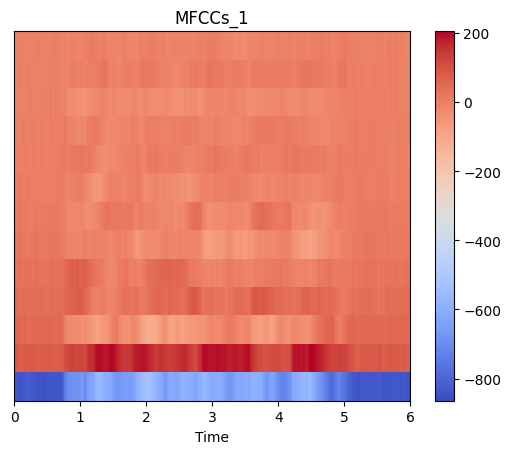

In [36]:
# Display the MFCCs
librosa.display.specshow(mfccs_angry[0], x_axis='time')
plt.colorbar()
plt.title('MFCCs_1')
plt.show()

In [37]:
mfccs_angry = compute_mfccs(mel_spectrogram_dbs_angry, num_mfcc=13)

100%|██████████| 2167/2167 [00:00<00:00, 4059.16it/s]


In [38]:
mfccs_disgusted = compute_mfccs(mel_spectrogram_dbs_disgusted, num_mfcc=13)

100%|██████████| 1863/1863 [00:00<00:00, 4476.98it/s]


In [39]:
mfccs_fearful = compute_mfccs(mel_spectrogram_dbs_fearful, num_mfcc=13)

100%|██████████| 2047/2047 [00:00<00:00, 4388.23it/s]


In [40]:
mfccs_happy = compute_mfccs(mel_spectrogram_dbs_happy, num_mfcc=13)

100%|██████████| 2167/2167 [00:00<00:00, 4018.49it/s]


In [41]:
mfccs_neutral = compute_mfccs(mel_spectrogram_dbs_neutral, num_mfcc=13)

100%|██████████| 1795/1795 [00:00<00:00, 4240.74it/s]


In [42]:
mfccs_sad = compute_mfccs(mel_spectrogram_dbs_sad, num_mfcc=13)

100%|██████████| 2167/2167 [00:00<00:00, 3866.73it/s]


In [43]:
mfccs_suprised = compute_mfccs(mel_spectrogram_dbs_suprised, num_mfcc=13)

100%|██████████| 592/592 [00:00<00:00, 4097.66it/s]


### Visualize the peaks in the MFCCs

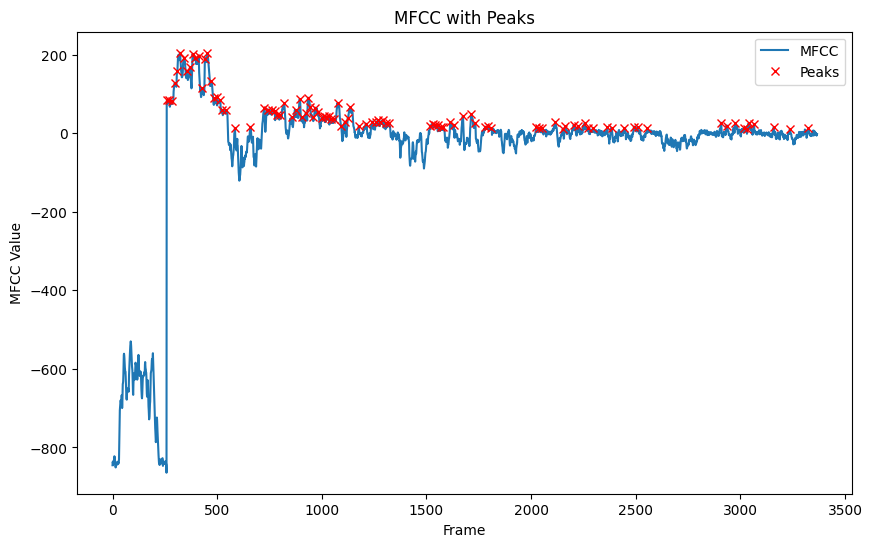

In [44]:
findPeeks(mfccs_angry[0],'MFCC')

### Compute FFT

100%|██████████| 2167/2167 [00:19<00:00, 110.92it/s]


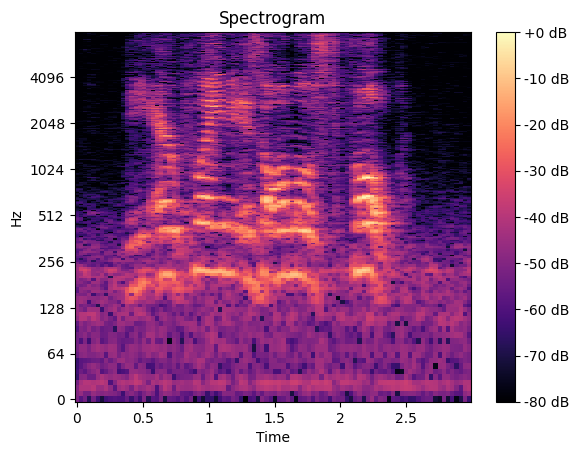

In [45]:
angry_sound = '/kaggle/input/audio-emotions/Emotions/Angry/'

signals = []
D = []
D_db = []
for filename in tqdm(os.listdir(angry_sound)):
    if filename.endswith(".wav"):
        signal, sample_rate = librosa.load(os.path.join(angry_sound, filename), sr=None)
        signals.append({'signal': signal, 'sample_rate': sample_rate})
        D_i = librosa.core.stft(signal)
        D.append(D_i)
        D_db_i = librosa.amplitude_to_db(np.abs(D_i), ref=np.max)
        D_db.append(D_db_i)
librosa.display.specshow(D_db[0], sr=signals[0]['sample_rate'], x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

### Split the mel_spectrogram features into X and Y

In [46]:
from tensorflow.image import resize

target_shape=(128,128)

X_angry = []
y_angry = []
for i in tqdm(range(len(mel_spectrogram_dbs_angry))):
    mel_spectrogram_angry = resize(np.expand_dims(mel_spectrogram_dbs_angry[i], axis=-1).astype(np.float64), target_shape)
    X_angry.append(mel_spectrogram_angry)
    y_angry.append(0)
print("Angry sounds splitted successfully")

###########################

X_disgusted = []
y_disgusted = []
for i in tqdm(range(len(mel_spectrogram_dbs_disgusted))):
    mel_spectrogram_disgusted = resize(np.expand_dims(mel_spectrogram_dbs_disgusted[i], axis=-1).astype(np.float64), target_shape)
    X_disgusted.append(mel_spectrogram_disgusted)
    y_disgusted.append(1)
print("Disgusted sounds splitted successfully")

####################################

X_fearful = []
y_fearful = []
for i in tqdm(range(len(mel_spectrogram_dbs_fearful))):
    mel_spectrogram_fearful = resize(np.expand_dims(mel_spectrogram_dbs_fearful[i], axis=-1).astype(np.float64), target_shape)
    X_fearful.append(mel_spectrogram_fearful)
    y_fearful.append(2)
print("Fearful sounds splitted successfully")

#############################################

X_happy = []
y_happy = []
for i in tqdm(range(len(mel_spectrogram_dbs_happy))):
    mel_spectrogram_happy = resize(np.expand_dims(mel_spectrogram_dbs_happy[i], axis=-1).astype(np.float64), target_shape)
    X_happy.append(mel_spectrogram_happy)
    y_happy.append(3)
print("Happy sounds splitted successfully")

################################

X_neutral = []
y_neutral = []
for i in tqdm(range(len(mel_spectrogram_dbs_neutral))):
    mel_spectrogram_neutral = resize(np.expand_dims(mel_spectrogram_dbs_neutral[i], axis=-1).astype(np.float64), target_shape)
    X_neutral.append(mel_spectrogram_neutral)
    y_neutral.append(4)
print("Neutral sounds splitted successfully")

###############################

X_sad = []
y_sad = []
for i in tqdm(range(len(mel_spectrogram_dbs_sad))):
    mel_spectrogram_sad = resize(np.expand_dims(mel_spectrogram_dbs_sad[i], axis=-1).astype(np.float64), target_shape)
    X_sad.append(mel_spectrogram_sad)
    y_sad.append(5)
print("Sad sounds splitted successfully")

#########################

X_suprised = []
y_suprised = []
for i in tqdm(range(len(mel_spectrogram_dbs_suprised))):
    mel_spectrogram_suprised = resize(np.expand_dims(mel_spectrogram_dbs_suprised[i], axis=-1).astype(np.float64), target_shape)
    X_suprised.append(mel_spectrogram_suprised)
    y_suprised.append(6)
print("Suprised sounds splitted successfully")

100%|██████████| 2167/2167 [00:02<00:00, 813.81it/s] 


Angry sounds splitted successfully


100%|██████████| 1863/1863 [00:01<00:00, 1161.05it/s]


Disgusted sounds splitted successfully


100%|██████████| 2047/2047 [00:01<00:00, 1226.31it/s]


Fearful sounds splitted successfully


100%|██████████| 2167/2167 [00:01<00:00, 1221.10it/s]


Happy sounds splitted successfully


100%|██████████| 1795/1795 [00:01<00:00, 1195.75it/s]


Neutral sounds splitted successfully


100%|██████████| 2167/2167 [00:01<00:00, 1228.09it/s]


Sad sounds splitted successfully


100%|██████████| 592/592 [00:00<00:00, 1227.33it/s]

Suprised sounds splitted successfully


In [47]:
X = X_angry + X_disgusted + X_fearful + X_happy + X_neutral + X_sad + X_suprised
y = y_angry + y_disgusted + y_fearful + y_happy + y_neutral + y_sad + y_suprised

In [48]:
X = np.array(X)
y = np.array(y)

In [49]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6])

In [50]:
Y = to_categorical(y, num_classes=7) 

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [52]:
Y.shape, y_train.shape, y_test.shape

((12798, 7), (10238, 7), (2560, 7))

In [53]:
X_train.shape, X_test.shape

((10238, 128, 128, 1), (2560, 128, 128, 1))

### Build The Model

In [54]:

input_shape = (128, 128, 1)
input_layer = Input(shape=input_shape)

conv1 = Conv2D(512, (3, 3), activation='relu', padding='same')(input_layer)
maxpool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(256, (3, 3), activation='relu', padding='same')(maxpool1)
maxpool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(maxpool2)
maxpool3 = MaxPooling2D((2, 2))(conv3)

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(maxpool3)
maxpool4 = MaxPooling2D((2, 2))(conv4)

conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(maxpool4)
maxpool5 = MaxPooling2D((2, 2))(conv5)

conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(maxpool5)
maxpool6 = MaxPooling2D((2, 2))(conv6)

flatten = Flatten()(maxpool6)
dense1 = Dense(32, activation='relu')(flatten)
output_layer = Dense(7, activation='softmax')(dense1)

model = Model(inputs=input_layer, outputs=output_layer)

model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 512)  │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,579,255 (6.02 MB)

 Trainable params: 1,579,255 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) 
check_pointer = ModelCheckpoint(filepath='clf-resnet-checkpoint.keras', verbose=1, save_best_only=True) 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001, factor=0.2) 
callbacks = [check_pointer,early_stopping,reduce_lr]

In [56]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [57]:
history = model.fit(
    X_train,
    y_train,
    validation_data = (X_test,y_test),
    epochs = 20,
    batch_size = 32,
    callbacks = callbacks
)

Epoch 1/20
  1/320 ━━━━━━━━━━━━━━━━━━━━ 3:19:55 38s/step - accuracy: 0.0625 - loss: 2.4814

I0000 00:00:1714401121.370237     139 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.1708 - loss: 1.9262
Epoch 1: val_loss improved from inf to 1.76944, saving model to clf-resnet-checkpoint.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 124s 271ms/step - accuracy: 0.1709 - loss: 1.9260 - val_accuracy: 0.2949 - val_loss: 1.7694 - learning_rate: 1.0000e-04
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.3214 - loss: 1.6684
Epoch 2: val_loss improved from 1.76944 to 1.37016, saving model to clf-resnet-checkpoint.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 49s 152ms/step - accuracy: 0.3215 - loss: 1.6681 - val_accuracy: 0.4496 - val_loss: 1.3702 - learning_rate: 1.0000e-04
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.4532 - loss: 1.3552
Epoch 3: val_loss improved from 1.37016 to 1.27572, saving model to clf-resnet-checkpoint.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 49s 152ms/step - accuracy: 0.4533 - loss: 1.3551 - val_accuracy: 0.5117 - val_loss: 1.2757 - learning_rate: 1.0000e-04
Epoch 4/20
320/320

In [58]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6519 - loss: 0.9636
Test accuracy: 0.653124988079071


### Plot Accuracy and Loss

<Figure size 2000x1500 with 0 Axes>

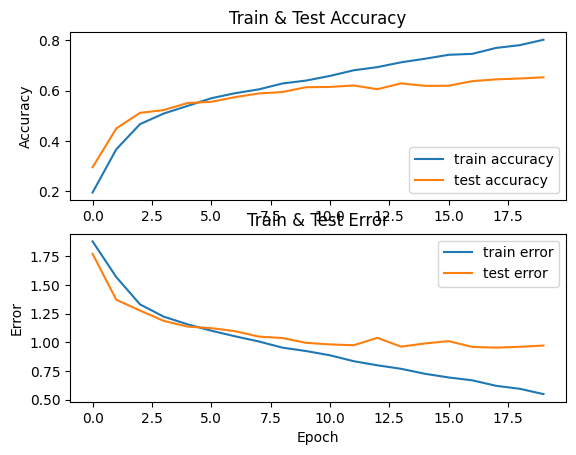

In [59]:
plt.figure(figsize=(20,15))
fig, axs = plt.subplots(2)

# accuracy 
axs[0].plot(history.history["accuracy"], label="train accuracy")
axs[0].plot(history.history["val_accuracy"], label="test accuracy")    
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Train & Test Accuracy")
    
# Error 
axs[1].plot(history.history["loss"], label="train error")
axs[1].plot(history.history["val_loss"], label="test error")    
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Train & Test Error")
    
plt.show()

In [60]:
prediction = model.predict(X_test) 

print(f" predicting a Two: \n{prediction}")
print(f" Largest Prediction index: {np.argmax(prediction)}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step
 predicting a Two: 
[[3.29874261e-08 1.59666491e-16 9.99999166e-01 ... 2.76938930e-14
  8.73434287e-14 3.37898030e-08]
 [1.03548225e-02 2.28671998e-01 2.39102170e-02 ... 6.76427424e-01
  5.20518050e-02 3.07647028e-08]
 [3.12147766e-01 1.52443886e-01 3.10849082e-02 ... 1.44949401e-04
  2.55949388e-04 3.08941935e-07]
 ...
 [3.65517451e-04 7.44370278e-04 7.14859962e-01 ... 5.97595499e-05
  1.04427010e-01 1.03288032e-02]
 [9.70431268e-01 2.92224083e-02 4.25652725e-05 ... 7.88781374e-10
  1.83525972e-05 6.32141173e-10]
 [2.40138629e-08 1.08417431e-09 1.21559235e-04 ... 1.20590415e-09
  6.84439783e-06 8.39957011e-08]]
 Largest Prediction index: 37


In [61]:
prediction_p = tf.nn.softmax(prediction)

print(f" predicting a Two. Probability vector: \n{prediction_p}")
print(f"Total of predictions: {np.sum(prediction_p):0.3f}")

 predicting a Two. Probability vector: 
[[0.11470153 0.11470152 0.31179076 ... 0.11470152 0.11470152 0.11470153]
 [0.12143712 0.15106556 0.12309446 ... 0.23638675 0.12660773 0.12018615]
 [0.16625968 0.1417191  0.12552287 ... 0.12169866 0.12171217 0.12168106]
 ...
 [0.11980567 0.11985107 0.24478137 ... 0.11976905 0.1329446  0.1210053 ]
 [0.30442464 0.11877307 0.11535738 ... 0.11535247 0.11535458 0.11535247]
 [0.11470441 0.11470441 0.11471835 ... 0.11470441 0.11470519 0.11470442]]
Total of predictions: 2560.000


In [62]:
#############################################################